In [1]:
!pip install pennylane
!pip install pennylane-qiskit
!pip install qiskit
!pip install qml
#!pip install tensorflow-macos

  Using cached qml-0.4.0.27.tar.gz (41 kB)
  Running setup.py clean for qml
Failed to build qml
    Running setup.py install for qml: started
    Running setup.py install for qml: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\gueha\anaconda3\envs\quantum\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\gueha\\AppData\\Local\\Temp\\pip-install-uj3qr0yi\\qml_e26fd7e820ad46d6b9eee82a0b7bec8d\\setup.py'"'"'; __file__='"'"'C:\\Users\\gueha\\AppData\\Local\\Temp\\pip-install-uj3qr0yi\\qml_e26fd7e820ad46d6b9eee82a0b7bec8d\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\gueha\AppData\Local\Temp\pip-wheel-hc0vkx9r'
       cwd: C:\Users\gueha\AppData\Local\Temp\pip-install-uj3qr0yi\qml_e26fd7e820ad46d6b9eee82a0b7bec8d\
  Complete output (69 lines):
  MKL-discover: MKLROOT was not set
  running bdist_wheel
  running build
  running config_cc
  INFO: unifing con

In [2]:
import warnings

#import pickle
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import scipy
from scipy.io import wavfile

import librosa
import librosa.display

import time as ti

import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers  import Conv2D, MaxPooling2D, Dense,Flatten, GRU, BatchNormalization, Conv1D, Dropout, Bidirectional,MaxPooling1D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, BatchNormalization, Conv1D, GRU, TimeDistributed, Activation, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy

import qiskit
import qiskit.providers.aer.noise as noise
from qiskit import IBMQ

## Local Definition 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
noise_mode = True # for running at QPU

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

n_w = 2 # numbers of wires def 2


if  noise_mode == True:
    #dev = qml.device('qiskit.aer', wires= n_w, noise_model=noise_model)
    #dev = qml.device('qiskit.ibmq', wires=n_w, backend='ibmq_qasm_simulator', provider=provider)
    dev = qml.device("default.mixed", wires= n_w)
else:
    #local quantum simulator
    dev = qml.device("default.qubit", wires= n_w)
    

In [4]:
n_layers = 1

# Random circuit parameters
rand_params1 = np.random.uniform(high= 2 * np.pi, size=(n_layers, n_w)) # def 2, n_w = 4


In [5]:
@qml.qnode(dev)
def circuit(p=0.01,phi=None):
    # Encoding of 4 classical input values
    for j in range(n_w):
        qml.RY(np.pi * phi[j], wires=j)
        qml.DepolarizingChannel(p, wires=j)

    # Random quantum circuit
    RandomLayers(rand_params1, wires=list(range(n_w)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_w)]

In [6]:
def quanv(image, kr=2, p=0.01):
    h_feat, w_feat, ch_n = image.shape
    """Convolves the input speech with many applications of the same quantum circuit."""
    out = np.zeros((h_feat//kr, w_feat//kr, n_w))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, h_feat-1, kr):
        for k in range(0, w_feat-1, kr):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                p,
                # kernal 3 ## phi=[image[j, k, 0], image[j, k + 1, 0], image[j, k + 2, 0], image[j + 1, k, 0], 
                # image[j + 1, k + 1, 0], image[j + 1, k +2 , 0],image[j+2, k, 0], image[j+2, k+1, 0], image[j+2, k+2, 0]]
                phi=[image[j, k, 0], image[j, k + 1, 0], image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_w):
                out[j // kr, k // kr, c] = q_results[c]
    return out

In [7]:
def gen_qspeech(x_train, x_valid, kr, p=0.01): # kernal size = 2x2 or 3x3
    q_train = []
    print("Quantum pre-processing of train Speech:")
    for idx, img in enumerate(x_train):
        print("{}/{}        ".format(idx + 1, len(x_train)), end="\r")
        q_train.append(quanv(img, kr, p))
    q_train = np.asarray(q_train)

    q_valid = []
    print("\nQuantum pre-processing of test Speech:")
    for idx, img in enumerate(x_valid):
        print("{}/{}        ".format(idx + 1, len(x_valid)), end="\r")
        q_valid.append(quanv(img, kr))
    q_valid = np.asarray(q_valid)
    
    return q_train, q_valid

In [8]:
def plot_acc_loss(q_history1, q_history2, q_history3, q_history4):

    plt.figure()
    plt.style.use("seaborn")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

    ax1.plot(q_history0.history["accuracy"], "-ok", label="with p=0")
    ax1.plot(q_history1.history["accuracy"], "-ok", label="with p=0.001")
    ax1.plot(q_history2.history["accuracy"], "-ob", label="with p=0.01")
    ax1.plot(q_history3.history["accuracy"], "-og", label="with p=0.1")
    ax1.plot(q_history4.history["accuracy"], "-og", label="with p=0.2")
    ax1.set_ylabel("Train Accuracy")
    ax1.set_ylim([0, 1.2])
    ax1.set_xlabel("Epoch")
    ax1.legend()

    ax2.plot(q_history0.history["val_accuracy"], "-ok", label="with p=0")
    ax2.plot(q_history1.history["val_accuracy"], "-ok", label="with p=0.001")
    ax2.plot(q_history2.history["val_accuracy"], "-ob", label="with p=0.01")
    ax2.plot(q_history3.history["val_accuracy"], "-og", label="with p=0.1")
    ax2.plot(q_history4.history["val_accuracy"], "-og", label="with p=0.2")
    ax2.set_ylabel("Test Accuracy")
    ax1.set_ylim([0, 1.2])
    #ax2.set_ylim(top=5.5)
    ax2.set_xlabel("Epoch")
    ax2.legend()
    plt.tight_layout()
    #plt.savefig("images/"+ data_ix +"_conv_speech_loss.png")

In [9]:
def show_speech(x_train, q_train, use_ch, idx, tmp = "tmp"):
    plt.figure()
    plt.subplot(5, 1, 1)
    if use_ch != True:
        librosa.display.specshow(librosa.power_to_db(x_train[idx,:,:,0], ref=np.max))
    else:
        librosa.display.specshow(librosa.power_to_db(x_train[idx,:,:], ref=np.max))
    plt.title('Input Speech: ' + tmp)

    for i in range(4):
        plt.subplot(5, 1, i+2)
        librosa.display.specshow(librosa.power_to_db(q_train[idx,:,:,i], ref=np.max))
        plt.title('Channel '+str(i+1)+': Quantum Compressed Speech')


    plt.tight_layout()
    plt.savefig("images/speech_encoder_" + tmp + ".png")

In [10]:
def show_stft_speech(x_train, q_train, use_ch, idx, tmp = "tmp"):
    plt.figure()
    plt.subplot(5, 1, 1)
    if use_ch != True:
        librosa.display.specshow(librosa.amplitude_to_db(x_train[idx,:,:,0], ref=np.max))
    else:
        librosa.display.specshow(librosa.amplitude_to_db(x_train[idx,:,:,0], ref=np.max))
    plt.title('Input Speech: ' + tmp)
    
    for i in range(4):
        plt.subplot(5, 1, i+2)
        librosa.display.specshow(librosa.amplitude_to_db(q_train[idx,:,:,1], ref=np.max))
        plt.title('Channel '+str(i+1)+': Quantum Compressed Speech')


In [11]:
def dense_Model(x, labels):
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    if len(x.shape) >= 3:
        h_feat,w_feat,ch_size = x.shape
        input_layer = keras.layers.Input(shape=(h_feat,w_feat,ch_size))
    else:
        h_feat,w_feat = x.shape
        input_layer = keras.layers.Input(shape=(h_feat,w_feat))
    model = keras.models.Sequential([
        input_layer,
        keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True),
        keras.layers.Flatten(),
        keras.layers.Dense(64),
        keras.layers.Dense(64),
        keras.layers.Dense(32),
        keras.layers.Dense(len(labels), activation="softmax")
    ])

    model.compile(
        optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [12]:
# define cnn model
def cnn_Model(h_feat, w_feat, labels):       
	model = Sequential()
	model.add(Conv2D(6, (2, 2), padding='valid', activation='relu', input_shape=(h_feat, w_feat, 1)))
	#model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(len(labels), activation='softmax'))
	# compile model
	opt = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [13]:
def attrnn_Model(x_in, labels, use_cnn=False, ablation = False):
    # simple LSTM
    rnn_func = L.LSTM
    use_Unet = True

    if len(x_in.shape) >= 3:
        h_feat,w_feat,ch_size = x_in.shape
        inputs = keras.layers.Input(shape=(h_feat, w_feat, ch_size))
    else:
        h_feat, w_feat = x_in.shape
        inputs = keras.layers.Input(shape=(h_feat, w_feat))

    inputs = L.Input(shape=(h_feat, w_feat, ch_size))

    if use_cnn == True:
        #x = L.Permute((2, 1, 3))(inputs)
        # First conv block
        x = L.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv1",
        )(inputs)
        x = L.MaxPooling2D((2, 2), name="pool1")(x)

        # Second conv block
        x = L.Conv2D(
            64,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv2",
        )(x)
        x = L.MaxPooling2D((2, 2), name="pool2")(x)
    else:
        x=inputs
        
    if ablation == True:
        x = L.Conv2D(4, (1, 1), strides=(2, 2), activation='relu', padding='same', name='abla_conv')(x)
        x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)
    else:
        x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = L.Permute((2, 1, 3))(x)

    if use_Unet == True:
        x = L.Conv2D(16, (5, 1), activation='relu', padding='same', name='ConvUp')(x)
        up = L.BatchNormalization()(x)
        x = L.Conv2D(32, (5, 1), activation='relu', padding='same', name='ConvDown1')(up)
        x = L.BatchNormalization()(x)
        x = L.Conv2D(16, (5, 1), activation='relu', padding='same', name='ConvDown2')(x)
        down = L.BatchNormalization()(x)
        merge = L.Concatenate(axis=3)([up,down])
        x = L.Conv2D(1, (5, 1), activation='relu', padding='same', name='ConvMerge')(merge)
        x = L.BatchNormalization()(x)
    else:
        x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
        x = L.BatchNormalization()(x)
        x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
        x = L.BatchNormalization()(x)

    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)


    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    # dot product attention
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(len(labels), activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [14]:
#%cd speech_quantum_dl
#from google.colab import drive

#drive.mount('/content/drive/', force_remount=True)
#%cd '/content/drive/My Drive/QuantumTeams/Pennylane Speech/'
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#!cd /content/drive/My\ Drive/Michael\ COVID\ audio\ data


In [15]:
data_ix = ti.strftime("%m%d_%H%M")
SAVE_PATH = "data_quantum/" # Data saving folder
#train_audio_path = '/content/drive/My Drive/QuantumTeams/Pennylane Speech'
train_audio_path = './'

In [16]:
def gen_mel(labels, train_audio_path, sr, port):
    all_wave = []
    all_label = []
    maxL=0
    minL=358321
    for label in tqdm(labels):
        waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
        for num, wav in enumerate(waves, 0):
            #print(wav)
            y, _ = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = sr)
            if len(y)>maxL:
                maxL =len(y)
            if len(y)<minL:
                minL =len(y)
            if num % port ==0:   # take 1/port samples
                if(len(y)>= 16000) :
                    mel_feat = librosa.feature.melspectrogram(y=y[0:16000], sr=sr, n_fft=1024, hop_length=128, center=True, power=1.0, n_mels=60, fmin=40.0, fmax=sr/2) #y[0:sr]
                    all_wave.append(np.expand_dims(mel_feat, axis=2))
                    all_label.append(label)
    print(maxL)
    print(minL)
    return all_wave, all_label

In [17]:
def gen_stft(labels, train_audio_path, sr, port):
    all_wave = []
    all_label = []
    windowLength = 1024
    window = scipy.signal.hamming(windowLength, sym=False)
    overlap      = round(0.25 * windowLength) # overlap of 75%
    for label in tqdm(labels):
        waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
        for num, wav in enumerate(waves, 0):
            y, _ = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = sr)
            if num % port ==0:   # take 1/port samples
                if(len(y)== sr) :
                    stft_feat = librosa.stft(y, n_fft=windowLength, win_length=windowLength, hop_length=128,
                            window=window, center=True)
                    all_wave.append(np.expand_dims(stft_feat, axis=2))
                    all_label.append(label)
    
    return all_wave, all_label

In [37]:
#want to change eps, bsize, sr to optimize
eps = 250
bsize = 16
sr = 48000
net = 1
mel = 0
quanv_mode = 1
# Quantum Layers
ql0 = 1
ql1 = 1
ql2 = 1
ql3 = 1
ql4 = 1
port = 1
labels = [
    'covid_segment','healthy_segment'
]

In [38]:
def gen_train(labels, train_audio_path, sr, port):
    all_wave, all_label = gen_mel(labels, train_audio_path, sr, port)
    #all_wave, all_label = gen_stft(labels, train_audio_path, sr, port)

    label_enconder = LabelEncoder()
    y = label_enconder.fit_transform(all_label)
    classes = list(label_enconder.classes_)
    y = keras.utils.to_categorical(y, num_classes=len(labels))

    from sklearn.model_selection import train_test_split
    x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)
    h_feat, w_feat, _ = x_train[0].shape
    np.save(SAVE_PATH + "21n_x_train_speech.npy", x_train)
    np.save(SAVE_PATH + "21n_x_test_speech.npy", x_valid)
    np.save(SAVE_PATH + "21n_y_train_speech.npy", y_train)
    np.save(SAVE_PATH + "21n_y_test_speech.npy", y_valid)
    print("===== Shape", h_feat, w_feat)

    return x_train, x_valid, y_train, y_valid

In [39]:
def gen_quanv(x_train, x_valid, kr, p):
    print("Kernal = ", kr)
    q_train, q_valid = gen_qspeech(x_train, x_valid, kr, p)

    np.save(SAVE_PATH + "2"+str(p) + "n_q_train_speech.npy", q_train)
    np.save(SAVE_PATH + "2"+str(p) + "n_q_test_speech.npy", q_valid)

    return q_train, q_valid

In [40]:
if mel == 1:
    x_train, x_valid, y_train, y_valid = gen_train(labels, train_audio_path, sr, port) 
else:
    x_train = np.load(SAVE_PATH + "41n_x_train_speech.npy")
    x_valid = np.load(SAVE_PATH + "41n_x_test_speech.npy")
    y_train = np.load(SAVE_PATH + "41n_y_train_speech.npy")
    y_valid = np.load(SAVE_PATH + "41n_y_test_speech.npy")

In [41]:
print("Xtrain len:", len(x_train))
print("XValid len:", len(x_valid))

zero_val = 0
one_val = 0
for i in y_valid:
    # get(key, default) falls back to default if key is not present
    if i[1] == 1:
        one_val = one_val + 1
    else:
        zero_val = zero_val + 1

print("Valid count")
print("Healthy:", one_val)
print("Covid:", zero_val)
print("Total:", one_val+zero_val)

zero_val = 0
one_val = 0
for i in y_train:
    # get(key, default) falls back to default if key is not present
    if i[1] == 1:
        one_val = one_val + 1
    else:
        zero_val = zero_val + 1

print("Train count")
print("Healthy:", one_val)
print("Covid:", zero_val)
print("Total:", one_val+zero_val)

Xtrain len: 688
XValid len: 172
Valid count
Healthy: 88
Covid: 84
Total: 172
Train count
Healthy: 353
Covid: 335
Total: 688


In [42]:
if quanv_mode == 1:
    if ql0 == 1:
        q_train0, q_valid0 = gen_quanv(x_train, x_valid, 2,0) 
    if ql1 == 1:
        q_train1, q_valid1 = gen_quanv(x_train, x_valid, 2,0.001) 
    if ql2 == 1:
        q_train2, q_valid2 = gen_quanv(x_train, x_valid, 2,0.01)
    if ql3 == 1:
        q_train3, q_valid3 = gen_quanv(x_train, x_valid, 2,0.1) 
    if ql4 == 1:
        q_train4, q_valid4 = gen_quanv(x_train, x_valid, 2,0.2) 
else:
    if ql0 == 1:
        q_train0 = np.load(SAVE_PATH + "20n_q_train_speech.npy")
        q_valid0 = np.load(SAVE_PATH + "20n_q_test_speech.npy")
    if ql1 == 1:
        q_train1 = np.load(SAVE_PATH + "20.001n_q_train_speech.npy")
        q_valid1 = np.load(SAVE_PATH + "20.001n_q_test_speech.npy")
    if ql2 == 1:
        q_train2 = np.load(SAVE_PATH + "20.01n_q_train_speech.npy")
        q_valid2 = np.load(SAVE_PATH + "20.01n_q_test_speech.npy")
    if ql3 == 1:
        q_train3 = np.load(SAVE_PATH + "20.1n_q_train_speech.npy")
        q_valid3 = np.load(SAVE_PATH + "20.1n_q_test_speech.npy")
    if ql4 == 1:
        q_train4 = np.load(SAVE_PATH + "20.2n_q_train_speech.npy")
        q_valid4 = np.load(SAVE_PATH + "20.2n_q_test_speech.npy")


Kernal =  2
Quantum pre-processing of train Speech:
688/688        
Quantum pre-processing of test Speech:
Kernal =  2    
Quantum pre-processing of train Speech:
688/688        
Quantum pre-processing of test Speech:
Kernal =  2    
Quantum pre-processing of train Speech:
688/688        
Quantum pre-processing of test Speech:
Kernal =  2    
Quantum pre-processing of train Speech:
688/688        
Quantum pre-processing of test Speech:
Kernal =  2    
Quantum pre-processing of train Speech:
688/688        
Quantum pre-processing of test Speech:


In [43]:
def search(list, platform):
    for i in range(len(list)):
        if list[i] == platform:
            return True
    return False

In [44]:
def searchIndex(list, platform):
    for i in range(len(list)):
        if list[i] == platform:
            return i
    return -1

In [45]:
idx=[]
thislist = []
ii = 0
for jj in range(len(y_train)):
    label=labels[searchIndex(y_train[jj],1)]
    if search(thislist, label) == False:
        thislist.append(label)
        print(label)
        idx.append(jj)

healthy_segment
covid_segment


In [46]:
librosa.amplitude_to_db(q_train1[2,:,:,1], ref=np.max)

array([[-3.39187076e-05, -1.02721244e-05, -1.11247515e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.76186606e-04, -1.50398723e-04, -5.40204192e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.41717813e-02, -6.21717412e-02, -7.35780573e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.76274080e-06, -5.28925934e-08, -1.65266378e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.61681508e-06, -4.82893725e-08, -1.52642832e-09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.13286175e-06, -3.40393520e-08, -2.08947526e-10, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

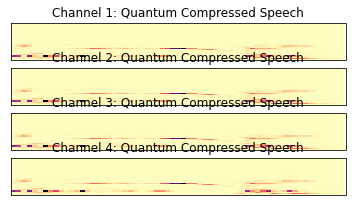

In [47]:
plt.figure()
for i in range(4):
    plt.subplot(5, 1, i+2)
    librosa.display.specshow(librosa.amplitude_to_db(q_train1[0,:,:,1], ref=np.max))
    plt.title('Channel '+str(i+1)+': Quantum Compressed Speech')

In [48]:
#S_db=librosa.amplitude_to_db(x_train[0,:,:,0],ref=np.max)
#plt.figure()
#librosa.display.specshow(S_db)
#plt.colorbar()

In [49]:
#for jj in range(len(idx)):
    #show_speech(x_train, q_train, False, idx[jj], tmp = labels[searchIndex(y_train[jj],1)])
    #show_stft_speech(x_train, q_train, False, idx[jj], tmp = labels[searchIndex(y_train[jj],1)])

In [50]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 15})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.title(title)
    plt.show()
    #%%

In [51]:
import IPython.display as ipd
import scipy
window = scipy.signal.hamming(1024, sym=False)

rev3 = librosa.feature.inverse.mel_to_audio(x_train[0,:,:,0], sr=sr, n_fft=1024,
                                                    hop_length=128,
                                                    win_length=1024, window=window,
                                                    center=True, pad_mode='reflect', power=1.0, n_iter=32, length=None)

ipd.Audio(data=rev3, rate=sr) # load a local WAV file

In [52]:
!pip install keras

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
## For Quanv Exp.
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('checkpoints/best_base_demo2.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

if net == 0:
    modelx = dense_Model(x_train[0], labels)
elif net == 1:
    modelx = attrnn_Model(x_train[0], labels)

modelx.summary()

x_history = modelx.fit(
    x=x_train, 
    y=y_train,
    epochs=eps, 
    callbacks=[checkpoint], 
    batch_size=bsize, 
    validation_data=(x_valid,y_valid)
)


keras.models.save_model(modelx, 'checkpoints/'+ data_ix + '_base_model_demo2.hdf5') 
modelx.save('checkpoints/'+ data_ix + '_base_demo2.hdf5')

print("=== Batch Size: ", bsize)

In [53]:
y_test=np.argmax(y_valid, axis=1)

y_pred=modelx.predict(x_valid)
y_pred1 = (y_pred > 0.5) 
y_pred=modelx.predict(x_train)
y_pred2 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred, axis=1)
print('\Base Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
print('\Base Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Baseline Confusion Matrix")

modelx=keras.models.load_model('checkpoints/best_base_demo2.hdf5') 
y_pred=modelx.predict(x_valid)
y_pred1 = (y_pred > 0.5) 
y_pred=modelx.predict(x_train)
y_pred2 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred, axis=1)
print('\Base Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
print('\Base Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Best Baseline Confusion Matrix")

## For Quanv Exp.
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=10, min_delta=0.0001)

checkpoint = ModelCheckpoint('checkpoints/best_conv_demo2.hdf5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

if net == 0:
    modelc= dense_Model(x_train[0], labels)
elif net == 1:
    modelc = attrnn_Model(x_train[0], labels,use_cnn=True)
    

#modelc = keras.models.load_model('checkpoints/0910_1843_base_sp2cmd.hdf5')
modelc.summary()

c_history = modelc.fit(
    x=x_train, 
    y=y_train,
    epochs=eps, 
    callbacks=[checkpoint], 
    batch_size=bsize, 
    validation_data=(x_valid,y_valid)
)

keras.models.save_model(modelc, 'checkpoints/'+ data_ix + '_conv_model_demo2.hdf5') 
modelc.save('checkpoints/'+ data_ix + '_conv_demo2.hdf5')

print("=== Batch Size: ", bsize)

y_pred=modelc.predict(x_valid)
y_pred1 = (y_pred > 0.5) 
y_pred=modelc.predict(x_train)
y_pred2 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_valid, axis=1)

print('\nConv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
print('\nConv Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Conv Confusion Matrix")

modelc=keras.models.load_model('checkpoints/best_conv_demo2.hdf5') 
y_pred=modelc.predict(x_valid)
y_pred1 = (y_pred > 0.5) 
y_pred=modelc.predict(x_train)
y_pred2 = (y_pred > 0.5) 

y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_valid, axis=1)

print('\nConv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
print('\nConv Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
cm = metrics.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = labels,
                      title        = "Best Conv Confusion Matrix")

In [69]:
if ql0 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo20.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq0 = attrnn_Model(q_train0[0], labels)

    modelq1.summary()

    q_history0 = modelq0.fit(
        x=q_train0, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid0,y_valid)
    )

    keras.models.save_model(modelq0, 'checkpoints/'+ data_ix + '_quanv_model_demo20.hdf5') 
    modelq1.save('checkpoints/'+ data_ix + '_demo20.hdf5')

    print("=== Batch Size: ", bsize)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 30, 63, 2)]  0           []                               
                                                                                                  
 batch_normalization_15 (BatchN  (None, 30, 63, 2)   8           ['input_8[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 permute_3 (Permute)            (None, 63, 30, 2)    0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 ConvUp (Conv2D)                (None, 63, 30, 16)   176         ['permute_3[0][0]']        

C:\Users\gueha\anaconda3\envs\quantum\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


43/43 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.5349
Epoch 1: val_accuracy improved from -inf to 0.48837, saving model to checkpoints\best_quanv_demo20.hdf5
43/43 [==============================] - 15s 151ms/step - loss: 0.6960 - accuracy: 0.5349 - val_loss: 0.7133 - val_accuracy: 0.4884
Epoch 2/250
43/43 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.5610
Epoch 2: val_accuracy did not improve from 0.48837
43/43 [==============================] - 4s 95ms/step - loss: 0.6827 - accuracy: 0.5610 - val_loss: 0.6942 - val_accuracy: 0.4709
Epoch 3/250
43/43 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.5916
Epoch 3: val_accuracy improved from 0.48837 to 0.51163, saving model to checkpoints\best_quanv_demo20.hdf5
43/43 [==============================] - 4s 94ms/step - loss: 0.6672 - accuracy: 0.5916 - val_loss: 0.7191 - val_accuracy: 0.5116
Epoch 4/250
43/43 [==============================] - ETA: 0s - loss: 0.65

43/43 [==============================] - 4s 94ms/step - loss: 0.2773 - accuracy: 0.8823 - val_loss: 1.2068 - val_accuracy: 0.5407
Epoch 30/250
43/43 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9273
Epoch 30: val_accuracy did not improve from 0.61047
43/43 [==============================] - 4s 91ms/step - loss: 0.1630 - accuracy: 0.9273 - val_loss: 1.6491 - val_accuracy: 0.5756
Epoch 31/250
43/43 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9186
Epoch 31: val_accuracy did not improve from 0.61047
43/43 [==============================] - 4s 92ms/step - loss: 0.1698 - accuracy: 0.9186 - val_loss: 1.5208 - val_accuracy: 0.5349
Epoch 32/250
43/43 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9041
Epoch 32: val_accuracy did not improve from 0.61047
43/43 [==============================] - 4s 91ms/step - loss: 0.2189 - accuracy: 0.9041 - val_loss: 1.7170 - val_accuracy: 0.5291
Epoch 33/250
43/43 [================

Epoch 59/250
43/43 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9709
Epoch 59: val_accuracy did not improve from 0.61628
43/43 [==============================] - 4s 91ms/step - loss: 0.0536 - accuracy: 0.9709 - val_loss: 2.0783 - val_accuracy: 0.5988
Epoch 60/250
43/43 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9564
Epoch 60: val_accuracy improved from 0.61628 to 0.63372, saving model to checkpoints\best_quanv_demo20.hdf5
43/43 [==============================] - 4s 93ms/step - loss: 0.1260 - accuracy: 0.9564 - val_loss: 1.5608 - val_accuracy: 0.6337
Epoch 61/250
43/43 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9273
Epoch 61: val_accuracy did not improve from 0.63372
43/43 [==============================] - 4s 97ms/step - loss: 0.1726 - accuracy: 0.9273 - val_loss: 1.4891 - val_accuracy: 0.5233
Epoch 62/250
43/43 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9622
Epoch 62: val_

43/43 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9608
Epoch 88: val_accuracy did not improve from 0.63372
43/43 [==============================] - 4s 93ms/step - loss: 0.1007 - accuracy: 0.9608 - val_loss: 2.1578 - val_accuracy: 0.5465
Epoch 89/250
43/43 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.9259
Epoch 89: val_accuracy did not improve from 0.63372
43/43 [==============================] - 4s 94ms/step - loss: 0.1766 - accuracy: 0.9259 - val_loss: 1.5487 - val_accuracy: 0.5814
Epoch 90/250
43/43 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9462
Epoch 90: val_accuracy did not improve from 0.63372
43/43 [==============================] - 4s 93ms/step - loss: 0.1276 - accuracy: 0.9462 - val_loss: 1.5105 - val_accuracy: 0.6163
Epoch 91/250
43/43 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.9680
Epoch 91: val_accuracy did not improve from 0.63372
43/43 [========================

43/43 [==============================] - 4s 95ms/step - loss: 0.0871 - accuracy: 0.9724 - val_loss: 2.0836 - val_accuracy: 0.6047
Epoch 118/250
43/43 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9622
Epoch 118: val_accuracy did not improve from 0.63372
43/43 [==============================] - 4s 93ms/step - loss: 0.0826 - accuracy: 0.9622 - val_loss: 1.9661 - val_accuracy: 0.6105
Epoch 119/250
43/43 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9840
Epoch 119: val_accuracy did not improve from 0.63372
43/43 [==============================] - 4s 94ms/step - loss: 0.0358 - accuracy: 0.9840 - val_loss: 2.3940 - val_accuracy: 0.5698
Epoch 120/250
43/43 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9753
Epoch 120: val_accuracy improved from 0.63372 to 0.65116, saving model to checkpoints\best_quanv_demo20.hdf5
43/43 [==============================] - 4s 95ms/step - loss: 0.0551 - accuracy: 0.9753 - val_loss: 1.77

Epoch 147/250
43/43 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9826
Epoch 147: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 93ms/step - loss: 0.0468 - accuracy: 0.9826 - val_loss: 2.9656 - val_accuracy: 0.5233
Epoch 148/250
43/43 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9811
Epoch 148: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 95ms/step - loss: 0.0459 - accuracy: 0.9811 - val_loss: 2.4101 - val_accuracy: 0.5523
Epoch 149/250
43/43 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9927
Epoch 149: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 95ms/step - loss: 0.0155 - accuracy: 0.9927 - val_loss: 2.5979 - val_accuracy: 0.5407
Epoch 150/250
43/43 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9971
Epoch 150: val_accuracy did not improve from 0.65116
43/43 [===

43/43 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9956
Epoch 176: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 95ms/step - loss: 0.0091 - accuracy: 0.9956 - val_loss: 2.3218 - val_accuracy: 0.5756
Epoch 177/250
43/43 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9971
Epoch 177: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 94ms/step - loss: 0.0063 - accuracy: 0.9971 - val_loss: 2.4895 - val_accuracy: 0.5756
Epoch 178/250
43/43 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9971
Epoch 178: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 93ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 2.5212 - val_accuracy: 0.5756
Epoch 179/250
43/43 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9942
Epoch 179: val_accuracy did not improve from 0.65116
43/43 [=================

43/43 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9956
Epoch 205: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 94ms/step - loss: 0.0060 - accuracy: 0.9956 - val_loss: 2.9550 - val_accuracy: 0.5581
Epoch 206/250
43/43 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9898
Epoch 206: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 94ms/step - loss: 0.0422 - accuracy: 0.9898 - val_loss: 2.5872 - val_accuracy: 0.6105
Epoch 207/250
43/43 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9971
Epoch 207: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 94ms/step - loss: 0.0163 - accuracy: 0.9971 - val_loss: 2.4004 - val_accuracy: 0.6047
Epoch 208/250
43/43 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 208: val_accuracy did not improve from 0.65116
43/43 [=================

Epoch 234/250
43/43 [==============================] - ETA: 0s - loss: 3.1508e-04 - accuracy: 1.0000
Epoch 234: val_accuracy did not improve from 0.65116
43/43 [==============================] - 3s 68ms/step - loss: 3.1508e-04 - accuracy: 1.0000 - val_loss: 3.4542 - val_accuracy: 0.5698
Epoch 235/250
43/43 [==============================] - ETA: 0s - loss: 1.1601e-04 - accuracy: 1.0000
Epoch 235: val_accuracy did not improve from 0.65116
43/43 [==============================] - 3s 64ms/step - loss: 1.1601e-04 - accuracy: 1.0000 - val_loss: 3.5409 - val_accuracy: 0.5756
Epoch 236/250
43/43 [==============================] - ETA: 0s - loss: 1.1905e-04 - accuracy: 1.0000
Epoch 236: val_accuracy did not improve from 0.65116
43/43 [==============================] - 3s 63ms/step - loss: 1.1905e-04 - accuracy: 1.0000 - val_loss: 3.5442 - val_accuracy: 0.5698
Epoch 237/250
43/43 [==============================] - ETA: 0s - loss: 8.6989e-05 - accuracy: 1.0000
Epoch 237: val_accuracy did not imp

In [70]:
if ql1 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo21.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq1 = attrnn_Model(q_train1[0], labels)

    modelq1.summary()

    q_history1 = modelq1.fit(
        x=q_train1, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid1,y_valid)
    )

    keras.models.save_model(modelq1, 'checkpoints/'+ data_ix + '_quanv_model_demo21.hdf5') 
    modelq1.save('checkpoints/'+ data_ix + '_demo21.hdf5')

    print("=== Batch Size: ", bsize)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 30, 63, 2)]  0           []                               
                                                                                                  
 batch_normalization_40 (BatchN  (None, 30, 63, 2)   8           ['input_18[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 permute_8 (Permute)            (None, 63, 30, 2)    0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 ConvUp (Conv2D)                (None, 63, 30, 16)   176         ['permute_8[0][0]']        

Epoch 8/250
43/43 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.6773
Epoch 8: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 92ms/step - loss: 0.5998 - accuracy: 0.6773 - val_loss: 0.6772 - val_accuracy: 0.5756
Epoch 9/250
43/43 [==============================] - ETA: 0s - loss: 0.5746 - accuracy: 0.6904
Epoch 9: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 90ms/step - loss: 0.5746 - accuracy: 0.6904 - val_loss: 0.9280 - val_accuracy: 0.5116
Epoch 10/250
43/43 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.7006
Epoch 10: val_accuracy improved from 0.59302 to 0.62791, saving model to checkpoints\best_quanv_demo21.hdf5
43/43 [==============================] - 4s 91ms/step - loss: 0.5569 - accuracy: 0.7006 - val_loss: 0.6290 - val_accuracy: 0.6279
Epoch 11/250
43/43 [==============================] - ETA: 0s - loss: 0.4886 - accuracy: 0.7267
Epoch 11: val_accu

43/43 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9956
Epoch 37: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 88ms/step - loss: 0.0182 - accuracy: 0.9956 - val_loss: 1.9908 - val_accuracy: 0.5291
Epoch 38/250
43/43 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9520
Epoch 38: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 90ms/step - loss: 0.1272 - accuracy: 0.9520 - val_loss: 1.8065 - val_accuracy: 0.5930
Epoch 39/250
43/43 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9346
Epoch 39: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 89ms/step - loss: 0.1422 - accuracy: 0.9346 - val_loss: 0.9975 - val_accuracy: 0.5523
Epoch 40/250
43/43 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9564
Epoch 40: val_accuracy did not improve from 0.62791
43/43 [========================

43/43 [==============================] - 4s 87ms/step - loss: 0.0264 - accuracy: 0.9927 - val_loss: 2.0064 - val_accuracy: 0.4826
Epoch 67/250
43/43 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9942
Epoch 67: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 87ms/step - loss: 0.0147 - accuracy: 0.9942 - val_loss: 2.2608 - val_accuracy: 0.5116
Epoch 68/250
43/43 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9971
Epoch 68: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 85ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 2.2790 - val_accuracy: 0.5058
Epoch 69/250
43/43 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9738
Epoch 69: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 85ms/step - loss: 0.0702 - accuracy: 0.9738 - val_loss: 2.3920 - val_accuracy: 0.5233
Epoch 70/250
43/43 [================

43/43 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9767
Epoch 96: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 87ms/step - loss: 0.0471 - accuracy: 0.9767 - val_loss: 3.4992 - val_accuracy: 0.5349
Epoch 97/250
43/43 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9869
Epoch 97: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 85ms/step - loss: 0.0447 - accuracy: 0.9869 - val_loss: 3.3165 - val_accuracy: 0.5407
Epoch 98/250
43/43 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9840
Epoch 98: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 85ms/step - loss: 0.0485 - accuracy: 0.9840 - val_loss: 1.6292 - val_accuracy: 0.5233
Epoch 99/250
43/43 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9927
Epoch 99: val_accuracy did not improve from 0.62791
43/43 [========================

Epoch 125/250
43/43 [==============================] - ETA: 0s - loss: 3.7023e-04 - accuracy: 1.0000
Epoch 125: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 85ms/step - loss: 3.7023e-04 - accuracy: 1.0000 - val_loss: 3.2329 - val_accuracy: 0.5814
Epoch 126/250
43/43 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9869
Epoch 126: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 85ms/step - loss: 0.0404 - accuracy: 0.9869 - val_loss: 3.0049 - val_accuracy: 0.5640
Epoch 127/250
43/43 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9884
Epoch 127: val_accuracy did not improve from 0.62791
43/43 [==============================] - 4s 87ms/step - loss: 0.0204 - accuracy: 0.9884 - val_loss: 1.8111 - val_accuracy: 0.5407
Epoch 128/250
43/43 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9898
Epoch 128: val_accuracy did not improve from 0.62791
43

Epoch 154/250
43/43 [==============================] - ETA: 0s - loss: 1.3982e-04 - accuracy: 1.0000
Epoch 154: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 85ms/step - loss: 1.3982e-04 - accuracy: 1.0000 - val_loss: 2.0531 - val_accuracy: 0.6105
Epoch 155/250
43/43 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 155: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 84ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.1557 - val_accuracy: 0.5814
Epoch 156/250
43/43 [==============================] - ETA: 0s - loss: 4.2047e-04 - accuracy: 1.0000
Epoch 156: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 85ms/step - loss: 4.2047e-04 - accuracy: 1.0000 - val_loss: 2.1561 - val_accuracy: 0.5756
Epoch 157/250
43/43 [==============================] - ETA: 0s - loss: 3.5074e-04 - accuracy: 1.0000
Epoch 157: val_accuracy did not improve fro

Epoch 183/250
43/43 [==============================] - ETA: 0s - loss: 5.1759e-04 - accuracy: 1.0000
Epoch 183: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 82ms/step - loss: 5.1759e-04 - accuracy: 1.0000 - val_loss: 2.3051 - val_accuracy: 0.5756
Epoch 184/250
43/43 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9985
Epoch 184: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 88ms/step - loss: 0.0018 - accuracy: 0.9985 - val_loss: 1.9054 - val_accuracy: 0.5872
Epoch 185/250
43/43 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 185: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 84ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.0335 - val_accuracy: 0.6047
Epoch 186/250
43/43 [==============================] - ETA: 0s - loss: 2.1567e-04 - accuracy: 1.0000
Epoch 186: val_accuracy did not improve from 0.6453

43/43 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9971
Epoch 212: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 85ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 2.6219 - val_accuracy: 0.5581
Epoch 213/250
43/43 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9956
Epoch 213: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 83ms/step - loss: 0.0086 - accuracy: 0.9956 - val_loss: 3.0856 - val_accuracy: 0.5523
Epoch 214/250
43/43 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9985
Epoch 214: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 83ms/step - loss: 0.0034 - accuracy: 0.9985 - val_loss: 3.2640 - val_accuracy: 0.5581
Epoch 215/250
43/43 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 215: val_accuracy did not improve from 0.64535
43/43 [=================

Epoch 241/250
43/43 [==============================] - ETA: 0s - loss: 6.9197e-05 - accuracy: 1.0000
Epoch 241: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 95ms/step - loss: 6.9197e-05 - accuracy: 1.0000 - val_loss: 3.0557 - val_accuracy: 0.5523
Epoch 242/250
43/43 [==============================] - ETA: 0s - loss: 7.0872e-05 - accuracy: 1.0000
Epoch 242: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 88ms/step - loss: 7.0872e-05 - accuracy: 1.0000 - val_loss: 3.0724 - val_accuracy: 0.5523
Epoch 243/250
43/43 [==============================] - ETA: 0s - loss: 6.9893e-05 - accuracy: 1.0000
Epoch 243: val_accuracy did not improve from 0.64535
43/43 [==============================] - 4s 85ms/step - loss: 6.9893e-05 - accuracy: 1.0000 - val_loss: 3.0954 - val_accuracy: 0.5523
Epoch 244/250
43/43 [==============================] - ETA: 0s - loss: 9.1348e-05 - accuracy: 1.0000
Epoch 244: val_accuracy did not imp

In [71]:
if ql2 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo22.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq2 = attrnn_Model(q_train2[0], labels)
    modelq2.summary()

    q_history2 = modelq2.fit(
        x=q_train2, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid2,y_valid)
    )

    keras.models.save_model(modelq2, 'checkpoints/'+ data_ix + '_quanv_mode_demo22.hdf5') 
    modelq2.save('checkpoints/'+ data_ix + '_demo22.hdf5')

    print("=== Batch Size: ", bsize)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 30, 63, 2)]  0           []                               
                                                                                                  
 batch_normalization_45 (BatchN  (None, 30, 63, 2)   8           ['input_20[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 permute_9 (Permute)            (None, 63, 30, 2)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 ConvUp (Conv2D)                (None, 63, 30, 16)   176         ['permute_9[0][0]']        

Epoch 8/250
43/43 [==============================] - ETA: 0s - loss: 0.5243 - accuracy: 0.7238
Epoch 8: val_accuracy improved from 0.52907 to 0.54651, saving model to checkpoints\best_quanv_demo22.hdf5
43/43 [==============================] - 4s 88ms/step - loss: 0.5243 - accuracy: 0.7238 - val_loss: 0.7122 - val_accuracy: 0.5465
Epoch 9/250
43/43 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.7747
Epoch 9: val_accuracy improved from 0.54651 to 0.56977, saving model to checkpoints\best_quanv_demo22.hdf5
43/43 [==============================] - 4s 88ms/step - loss: 0.4517 - accuracy: 0.7747 - val_loss: 0.7381 - val_accuracy: 0.5698
Epoch 10/250
43/43 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.7994
Epoch 10: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 86ms/step - loss: 0.4210 - accuracy: 0.7994 - val_loss: 0.9453 - val_accuracy: 0.5291
Epoch 11/250
43/43 [==============================] - ETA:

43/43 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9506
Epoch 36: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 87ms/step - loss: 0.1222 - accuracy: 0.9506 - val_loss: 1.5041 - val_accuracy: 0.5523
Epoch 37/250
43/43 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9840
Epoch 37: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 88ms/step - loss: 0.0423 - accuracy: 0.9840 - val_loss: 1.6485 - val_accuracy: 0.5640
Epoch 38/250
43/43 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9942
Epoch 38: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 86ms/step - loss: 0.0137 - accuracy: 0.9942 - val_loss: 1.6928 - val_accuracy: 0.6163
Epoch 39/250
43/43 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9971
Epoch 39: val_accuracy did not improve from 0.65116
43/43 [========================

43/43 [==============================] - 4s 86ms/step - loss: 0.0024 - accuracy: 0.9985 - val_loss: 2.1354 - val_accuracy: 0.6221
Epoch 66/250
43/43 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 66: val_accuracy did not improve from 0.65116
43/43 [==============================] - 4s 88ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.9212 - val_accuracy: 0.6512
Epoch 67/250
43/43 [==============================] - ETA: 0s - loss: 5.3163e-04 - accuracy: 1.0000
Epoch 67: val_accuracy improved from 0.65116 to 0.66279, saving model to checkpoints\best_quanv_demo22.hdf5
43/43 [==============================] - 4s 89ms/step - loss: 5.3163e-04 - accuracy: 1.0000 - val_loss: 1.9148 - val_accuracy: 0.6628
Epoch 68/250
43/43 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9985
Epoch 68: val_accuracy did not improve from 0.66279
43/43 [==============================] - 4s 88ms/step - loss: 0.0034 - accuracy: 0.9985 - val_loss: 2.

Epoch 95/250
43/43 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000
Epoch 95: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 88ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.6772 - val_accuracy: 0.6221
Epoch 96/250
43/43 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 96: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.7327 - val_accuracy: 0.6512
Epoch 97/250
43/43 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9985
Epoch 97: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 88ms/step - loss: 0.0035 - accuracy: 0.9985 - val_loss: 1.7748 - val_accuracy: 0.6628
Epoch 98/250
43/43 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9956
Epoch 98: val_accuracy did not improve from 0.66860
43/43 [===========

Epoch 124/250
43/43 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9985
Epoch 124: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 83ms/step - loss: 0.0036 - accuracy: 0.9985 - val_loss: 2.7608 - val_accuracy: 0.6105
Epoch 125/250
43/43 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 125: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 83ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.7873 - val_accuracy: 0.6047
Epoch 126/250
43/43 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9913
Epoch 126: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 83ms/step - loss: 0.0204 - accuracy: 0.9913 - val_loss: 3.5513 - val_accuracy: 0.5640
Epoch 127/250
43/43 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9709
Epoch 127: val_accuracy did not improve from 0.66860
43/43 [===

43/43 [==============================] - ETA: 0s - loss: 8.1467e-04 - accuracy: 1.0000
Epoch 153: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 8.1467e-04 - accuracy: 1.0000 - val_loss: 2.4121 - val_accuracy: 0.6163
Epoch 154/250
43/43 [==============================] - ETA: 0s - loss: 5.8285e-04 - accuracy: 1.0000
Epoch 154: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 5.8285e-04 - accuracy: 1.0000 - val_loss: 2.4150 - val_accuracy: 0.6512
Epoch 155/250
43/43 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 155: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.3908 - val_accuracy: 0.6221
Epoch 156/250
43/43 [==============================] - ETA: 0s - loss: 2.4721e-04 - accuracy: 1.0000
Epoch 156: val_accuracy did not improve from 0.66860
43/4

Epoch 182/250
43/43 [==============================] - ETA: 0s - loss: 2.0361e-04 - accuracy: 1.0000
Epoch 182: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 2.0361e-04 - accuracy: 1.0000 - val_loss: 2.3901 - val_accuracy: 0.6105
Epoch 183/250
43/43 [==============================] - ETA: 0s - loss: 1.4773e-04 - accuracy: 1.0000
Epoch 183: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 86ms/step - loss: 1.4773e-04 - accuracy: 1.0000 - val_loss: 2.4056 - val_accuracy: 0.6105
Epoch 184/250
43/43 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9855
Epoch 184: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 88ms/step - loss: 0.0541 - accuracy: 0.9855 - val_loss: 2.8544 - val_accuracy: 0.5058
Epoch 185/250
43/43 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9913
Epoch 185: val_accuracy did not improve from 0.

Epoch 211/250
43/43 [==============================] - ETA: 0s - loss: 7.4700e-04 - accuracy: 1.0000
Epoch 211: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 87ms/step - loss: 7.4700e-04 - accuracy: 1.0000 - val_loss: 2.3904 - val_accuracy: 0.6105
Epoch 212/250
43/43 [==============================] - ETA: 0s - loss: 2.4130e-04 - accuracy: 1.0000
Epoch 212: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 86ms/step - loss: 2.4130e-04 - accuracy: 1.0000 - val_loss: 2.4138 - val_accuracy: 0.6047
Epoch 213/250
43/43 [==============================] - ETA: 0s - loss: 1.1468e-04 - accuracy: 1.0000
Epoch 213: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 1.1468e-04 - accuracy: 1.0000 - val_loss: 2.4486 - val_accuracy: 0.6105
Epoch 214/250
43/43 [==============================] - ETA: 0s - loss: 1.0048e-04 - accuracy: 1.0000
Epoch 214: val_accuracy did not imp

43/43 [==============================] - 4s 85ms/step - loss: 0.0087 - accuracy: 0.9956 - val_loss: 3.2942 - val_accuracy: 0.5581
Epoch 240/250
43/43 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9797
Epoch 240: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 86ms/step - loss: 0.0976 - accuracy: 0.9797 - val_loss: 2.4438 - val_accuracy: 0.5465
Epoch 241/250
43/43 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9840
Epoch 241: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 87ms/step - loss: 0.0401 - accuracy: 0.9840 - val_loss: 1.7356 - val_accuracy: 0.5698
Epoch 242/250
43/43 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9942
Epoch 242: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0135 - accuracy: 0.9942 - val_loss: 1.8824 - val_accuracy: 0.5756
Epoch 243/250
43/43 [=========

In [72]:
if ql3 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo23.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq3 = attrnn_Model(q_train3[0], labels)

    modelq3.summary()

    q_history3 = modelq3.fit(
        x=q_train3, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid3,y_valid)
    )

    keras.models.save_model(modelq3, 'checkpoints/'+ data_ix + '_quanv_mode_demo23.hdf5') 
    modelq3.save('checkpoints/'+ data_ix + '_demo23.hdf5')

    print("=== Batch Size: ", bsize)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 30, 63, 2)]  0           []                               
                                                                                                  
 batch_normalization_50 (BatchN  (None, 30, 63, 2)   8           ['input_22[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 permute_10 (Permute)           (None, 63, 30, 2)    0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 ConvUp (Conv2D)                (None, 63, 30, 16)   176         ['permute_10[0][0]']      

Epoch 8/250
43/43 [==============================] - ETA: 0s - loss: 0.6126 - accuracy: 0.6497
Epoch 8: val_accuracy did not improve from 0.58140
43/43 [==============================] - 2s 57ms/step - loss: 0.6126 - accuracy: 0.6497 - val_loss: 0.6941 - val_accuracy: 0.5581
Epoch 9/250
43/43 [==============================] - ETA: 0s - loss: 0.5971 - accuracy: 0.6337
Epoch 9: val_accuracy did not improve from 0.58140
43/43 [==============================] - 3s 74ms/step - loss: 0.5971 - accuracy: 0.6337 - val_loss: 0.7043 - val_accuracy: 0.5291
Epoch 10/250
43/43 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.6933
Epoch 10: val_accuracy did not improve from 0.58140
43/43 [==============================] - 3s 67ms/step - loss: 0.5600 - accuracy: 0.6933 - val_loss: 0.8298 - val_accuracy: 0.5581
Epoch 11/250
43/43 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.6555
Epoch 11: val_accuracy did not improve from 0.58140
43/43 [===============

Epoch 37/250
43/43 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.8823
Epoch 37: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 86ms/step - loss: 0.2434 - accuracy: 0.8823 - val_loss: 1.8828 - val_accuracy: 0.5233
Epoch 38/250
43/43 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.9070
Epoch 38: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 86ms/step - loss: 0.2335 - accuracy: 0.9070 - val_loss: 1.2022 - val_accuracy: 0.5640
Epoch 39/250
43/43 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.9128
Epoch 39: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 84ms/step - loss: 0.2105 - accuracy: 0.9128 - val_loss: 1.4294 - val_accuracy: 0.6105
Epoch 40/250
43/43 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9302
Epoch 40: val_accuracy did not improve from 0.66860
43/43 [===========

43/43 [==============================] - 4s 86ms/step - loss: 0.0369 - accuracy: 0.9767 - val_loss: 2.2499 - val_accuracy: 0.5581
Epoch 67/250
43/43 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9840
Epoch 67: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 86ms/step - loss: 0.0260 - accuracy: 0.9840 - val_loss: 2.4472 - val_accuracy: 0.5872
Epoch 68/250
43/43 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9855
Epoch 68: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0254 - accuracy: 0.9855 - val_loss: 2.5089 - val_accuracy: 0.5640
Epoch 69/250
43/43 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9826
Epoch 69: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 87ms/step - loss: 0.0239 - accuracy: 0.9826 - val_loss: 2.5836 - val_accuracy: 0.5581
Epoch 70/250
43/43 [================

43/43 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9869
Epoch 96: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 83ms/step - loss: 0.0183 - accuracy: 0.9869 - val_loss: 2.9311 - val_accuracy: 0.5291
Epoch 97/250
43/43 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9884
Epoch 97: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0179 - accuracy: 0.9884 - val_loss: 2.9332 - val_accuracy: 0.5465
Epoch 98/250
43/43 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9869
Epoch 98: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 83ms/step - loss: 0.0187 - accuracy: 0.9869 - val_loss: 2.9444 - val_accuracy: 0.5465
Epoch 99/250
43/43 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9840
Epoch 99: val_accuracy did not improve from 0.66860
43/43 [========================

43/43 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9855
Epoch 125: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0171 - accuracy: 0.9855 - val_loss: 3.1576 - val_accuracy: 0.5581
Epoch 126/250
43/43 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9884
Epoch 126: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0164 - accuracy: 0.9884 - val_loss: 3.1388 - val_accuracy: 0.5814
Epoch 127/250
43/43 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9898
Epoch 127: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0165 - accuracy: 0.9898 - val_loss: 3.1595 - val_accuracy: 0.5930
Epoch 128/250
43/43 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9913
Epoch 128: val_accuracy did not improve from 0.66860
43/43 [=================

43/43 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9375
Epoch 154: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 87ms/step - loss: 0.1350 - accuracy: 0.9375 - val_loss: 2.2192 - val_accuracy: 0.5058
Epoch 155/250
43/43 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9520
Epoch 155: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.1124 - accuracy: 0.9520 - val_loss: 1.6926 - val_accuracy: 0.5465
Epoch 156/250
43/43 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9564
Epoch 156: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.1105 - accuracy: 0.9564 - val_loss: 1.3684 - val_accuracy: 0.5581
Epoch 157/250
43/43 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9709
Epoch 157: val_accuracy did not improve from 0.66860
43/43 [=================

43/43 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9869
Epoch 183: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 83ms/step - loss: 0.0174 - accuracy: 0.9869 - val_loss: 3.1419 - val_accuracy: 0.5349
Epoch 184/250
43/43 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9869
Epoch 184: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 84ms/step - loss: 0.0190 - accuracy: 0.9869 - val_loss: 3.1787 - val_accuracy: 0.5291
Epoch 185/250
43/43 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9884
Epoch 185: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0185 - accuracy: 0.9884 - val_loss: 3.2615 - val_accuracy: 0.5233
Epoch 186/250
43/43 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9898
Epoch 186: val_accuracy did not improve from 0.66860
43/43 [=================

43/43 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9855
Epoch 212: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0246 - accuracy: 0.9855 - val_loss: 2.0359 - val_accuracy: 0.5930
Epoch 213/250
43/43 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9811
Epoch 213: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 84ms/step - loss: 0.0224 - accuracy: 0.9811 - val_loss: 2.1427 - val_accuracy: 0.5756
Epoch 214/250
43/43 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9884
Epoch 214: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0196 - accuracy: 0.9884 - val_loss: 2.2099 - val_accuracy: 0.5756
Epoch 215/250
43/43 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9884
Epoch 215: val_accuracy did not improve from 0.66860
43/43 [=================

43/43 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9782
Epoch 241: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 86ms/step - loss: 0.0357 - accuracy: 0.9782 - val_loss: 2.3420 - val_accuracy: 0.5814
Epoch 242/250
43/43 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9869
Epoch 242: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 86ms/step - loss: 0.0314 - accuracy: 0.9869 - val_loss: 2.6258 - val_accuracy: 0.5930
Epoch 243/250
43/43 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9767
Epoch 243: val_accuracy did not improve from 0.66860
43/43 [==============================] - 4s 85ms/step - loss: 0.0437 - accuracy: 0.9767 - val_loss: 2.4589 - val_accuracy: 0.6105
Epoch 244/250
43/43 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9840
Epoch 244: val_accuracy did not improve from 0.66860
43/43 [=================

In [73]:
if ql4 == 1:
    ## For Quanv Exp.
    early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                               verbose=1, patience=10, min_delta=0.0001)

    checkpoint = ModelCheckpoint('checkpoints/best_quanv_demo24.hdf5', monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    if net == 0:
        modelq = dense_Model(x_train[0], labels)
    elif net == 1:
        modelq4 = attrnn_Model(q_train4[0], labels)
    modelq4.summary()

    q_history4 = modelq4.fit(
        x=q_train4, 
        y=y_train,
        epochs=eps, 
        callbacks=[checkpoint], 
        batch_size=bsize, 
        validation_data=(q_valid4,y_valid)
    )

    keras.models.save_model(modelq4, 'checkpoints/'+ data_ix + '_quanv_model_demo24.hdf5') 
    modelq4.save('checkpoints/'+ data_ix + '_demo24.hdf5')

    print("=== Batch Size: ", bsize)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 30, 63, 2)]  0           []                               
                                                                                                  
 batch_normalization_55 (BatchN  (None, 30, 63, 2)   8           ['input_24[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 permute_11 (Permute)           (None, 63, 30, 2)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 ConvUp (Conv2D)                (None, 63, 30, 16)   176         ['permute_11[0][0]']      

43/43 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.6017
Epoch 8: val_accuracy did not improve from 0.55814
43/43 [==============================] - 3s 59ms/step - loss: 0.6461 - accuracy: 0.6017 - val_loss: 0.7599 - val_accuracy: 0.4942
Epoch 9/250
43/43 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.6235
Epoch 9: val_accuracy did not improve from 0.55814
43/43 [==============================] - 2s 56ms/step - loss: 0.6379 - accuracy: 0.6235 - val_loss: 0.7559 - val_accuracy: 0.5058
Epoch 10/250
43/43 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.6294
Epoch 10: val_accuracy did not improve from 0.55814
43/43 [==============================] - 2s 56ms/step - loss: 0.6287 - accuracy: 0.6294 - val_loss: 0.8753 - val_accuracy: 0.4884
Epoch 11/250
43/43 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.6366
Epoch 11: val_accuracy did not improve from 0.55814
43/43 [===========================

43/43 [==============================] - ETA: 0s - loss: 0.4107 - accuracy: 0.8198
Epoch 37: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 88ms/step - loss: 0.4107 - accuracy: 0.8198 - val_loss: 1.0558 - val_accuracy: 0.4884
Epoch 38/250
43/43 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.8241
Epoch 38: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 87ms/step - loss: 0.3982 - accuracy: 0.8241 - val_loss: 1.1147 - val_accuracy: 0.4709
Epoch 39/250
43/43 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8401
Epoch 39: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 86ms/step - loss: 0.3430 - accuracy: 0.8401 - val_loss: 1.2906 - val_accuracy: 0.4884
Epoch 40/250
43/43 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.8430
Epoch 40: val_accuracy did not improve from 0.56977
43/43 [========================

43/43 [==============================] - 4s 96ms/step - loss: 0.2234 - accuracy: 0.9142 - val_loss: 1.0602 - val_accuracy: 0.4651
Epoch 67/250
43/43 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9506
Epoch 67: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 92ms/step - loss: 0.1300 - accuracy: 0.9506 - val_loss: 1.0756 - val_accuracy: 0.4884
Epoch 68/250
43/43 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9419
Epoch 68: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 91ms/step - loss: 0.1329 - accuracy: 0.9419 - val_loss: 1.3175 - val_accuracy: 0.4826
Epoch 69/250
43/43 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9201
Epoch 69: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 90ms/step - loss: 0.1846 - accuracy: 0.9201 - val_loss: 1.0500 - val_accuracy: 0.5174
Epoch 70/250
43/43 [================

43/43 [==============================] - ETA: 0s - loss: 0.0561 - accuracy: 0.9826
Epoch 96: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 91ms/step - loss: 0.0561 - accuracy: 0.9826 - val_loss: 1.4118 - val_accuracy: 0.4477
Epoch 97/250
43/43 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9797
Epoch 97: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 90ms/step - loss: 0.0459 - accuracy: 0.9797 - val_loss: 1.5589 - val_accuracy: 0.5058
Epoch 98/250
43/43 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.9651
Epoch 98: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 90ms/step - loss: 0.0857 - accuracy: 0.9651 - val_loss: 2.0827 - val_accuracy: 0.4651
Epoch 99/250
43/43 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9855
Epoch 99: val_accuracy did not improve from 0.56977
43/43 [========================

43/43 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9913
Epoch 125: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 91ms/step - loss: 0.0207 - accuracy: 0.9913 - val_loss: 2.0317 - val_accuracy: 0.5291
Epoch 126/250
43/43 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9971
Epoch 126: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 90ms/step - loss: 0.0160 - accuracy: 0.9971 - val_loss: 2.1679 - val_accuracy: 0.5349
Epoch 127/250
43/43 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9869
Epoch 127: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 91ms/step - loss: 0.0318 - accuracy: 0.9869 - val_loss: 2.2960 - val_accuracy: 0.5058
Epoch 128/250
43/43 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9971
Epoch 128: val_accuracy did not improve from 0.56977
43/43 [=================

43/43 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9738
Epoch 154: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 89ms/step - loss: 0.0667 - accuracy: 0.9738 - val_loss: 2.6710 - val_accuracy: 0.4942
Epoch 155/250
43/43 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9840
Epoch 155: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 89ms/step - loss: 0.0575 - accuracy: 0.9840 - val_loss: 2.7822 - val_accuracy: 0.4884
Epoch 156/250
43/43 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9913
Epoch 156: val_accuracy did not improve from 0.56977
43/43 [==============================] - 4s 93ms/step - loss: 0.0258 - accuracy: 0.9913 - val_loss: 2.5862 - val_accuracy: 0.4884
Epoch 157/250
43/43 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9767
Epoch 157: val_accuracy did not improve from 0.56977
43/43 [=================

Epoch 183/250
43/43 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9898
Epoch 183: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 90ms/step - loss: 0.0291 - accuracy: 0.9898 - val_loss: 1.9166 - val_accuracy: 0.5698
Epoch 184/250
43/43 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9927
Epoch 184: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 92ms/step - loss: 0.0212 - accuracy: 0.9927 - val_loss: 2.0245 - val_accuracy: 0.5291
Epoch 185/250
43/43 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9971
Epoch 185: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 92ms/step - loss: 0.0119 - accuracy: 0.9971 - val_loss: 2.0331 - val_accuracy: 0.5349
Epoch 186/250
43/43 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9840
Epoch 186: val_accuracy did not improve from 0.59302
43/43 [===

Epoch 212/250
43/43 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9869
Epoch 212: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 93ms/step - loss: 0.0456 - accuracy: 0.9869 - val_loss: 2.0867 - val_accuracy: 0.5116
Epoch 213/250
43/43 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9913
Epoch 213: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 93ms/step - loss: 0.0260 - accuracy: 0.9913 - val_loss: 1.8210 - val_accuracy: 0.5174
Epoch 214/250
43/43 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9898
Epoch 214: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 91ms/step - loss: 0.0245 - accuracy: 0.9898 - val_loss: 2.3513 - val_accuracy: 0.5174
Epoch 215/250
43/43 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9942
Epoch 215: val_accuracy did not improve from 0.59302
43/43 [===

43/43 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9956
Epoch 241: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 91ms/step - loss: 0.0103 - accuracy: 0.9956 - val_loss: 2.4272 - val_accuracy: 0.5116
Epoch 242/250
43/43 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9971
Epoch 242: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 93ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 2.8939 - val_accuracy: 0.5116
Epoch 243/250
43/43 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 243: val_accuracy did not improve from 0.59302
43/43 [==============================] - 4s 91ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 3.1053 - val_accuracy: 0.5058
Epoch 244/250
43/43 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 244: val_accuracy did not improve from 0.59302
43/43 [=================

22/22 [==============================] - 1s 35ms/step

Quanv Train Accuracy: 1.00


Quanv Valid Accuracy: 0.58



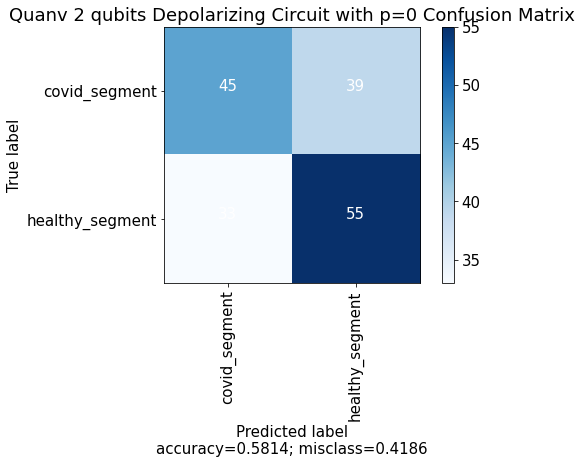

22/22 [==============================] - 1s 36ms/step

Quanv Train Accuracy: 0.98


Quanv Valid Accuracy: 0.65



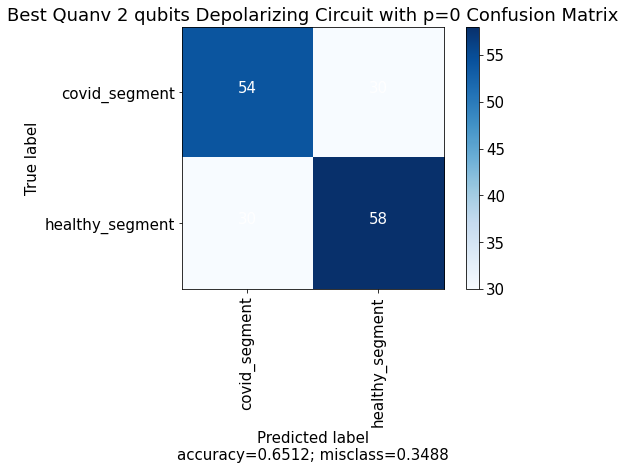

In [74]:
if ql0 == 1:
    modelq=modelq0 
    y_pred=modelq.predict(q_valid0)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train0)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 2 qubits Depolarizing Circuit with p=0 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo20.hdf5') 
    y_pred=modelq.predict(q_valid0)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train0)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 2 qubits Depolarizing Circuit with p=0 Confusion Matrix")

22/22 [==============================] - 1s 32ms/step

Quanv Train Accuracy: 1.00


Quanv Valid Accuracy: 0.56



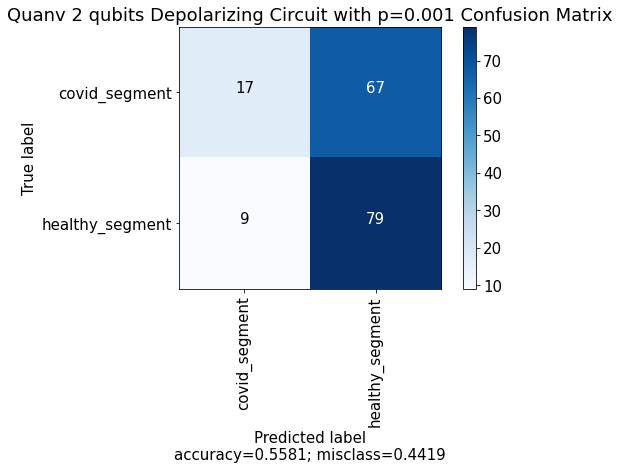

22/22 [==============================] - 1s 33ms/step

Quanv Train Accuracy: 0.63


Quanv Valid Accuracy: 0.65



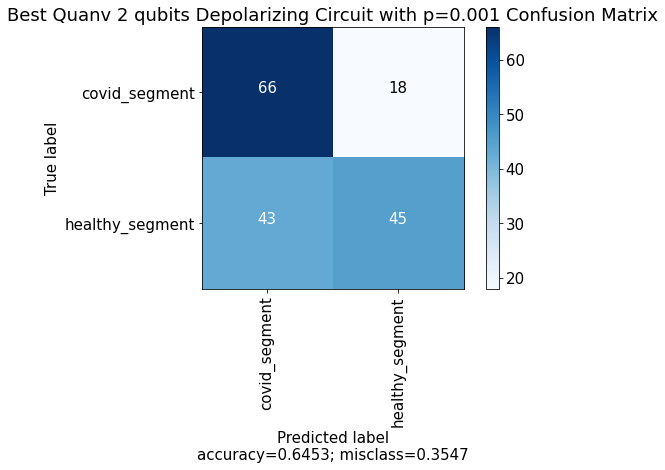

In [75]:
if ql1 == 1:
    modelq=modelq1 
    y_pred=modelq.predict(q_valid1)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train1)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 2 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo21.hdf5') 
    y_pred=modelq.predict(q_valid1)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train1)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 2 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")

22/22 [==============================] - 1s 33ms/step

Quanv Train Accuracy: 1.00


Quanv Valid Accuracy: 0.56



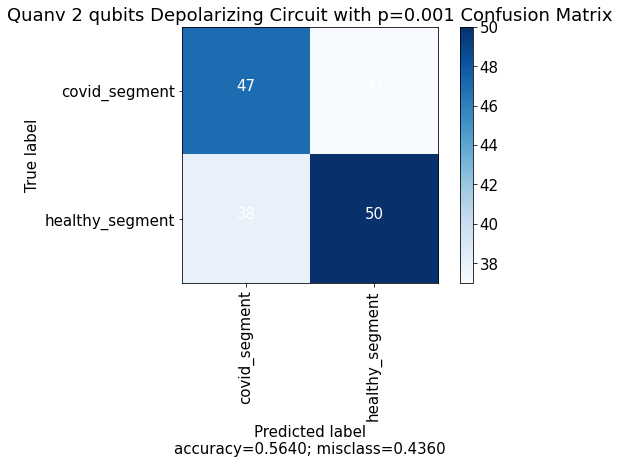

22/22 [==============================] - 1s 33ms/step

Quanv Train Accuracy: 1.00


Quanv Valid Accuracy: 0.67



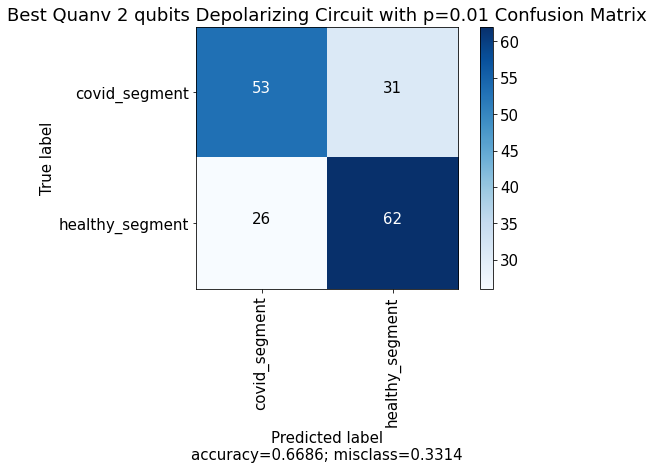

In [76]:
if ql2 == 1:
    modelq=modelq2 
    y_pred=modelq.predict(q_valid2)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train2)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 2 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo22.hdf5') 
    y_pred=modelq.predict(q_valid2)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train2)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 2 qubits Depolarizing Circuit with p=0.01 Confusion Matrix")

22/22 [==============================] - 1s 34ms/step

Quanv Train Accuracy: 0.99


Quanv Valid Accuracy: 0.59



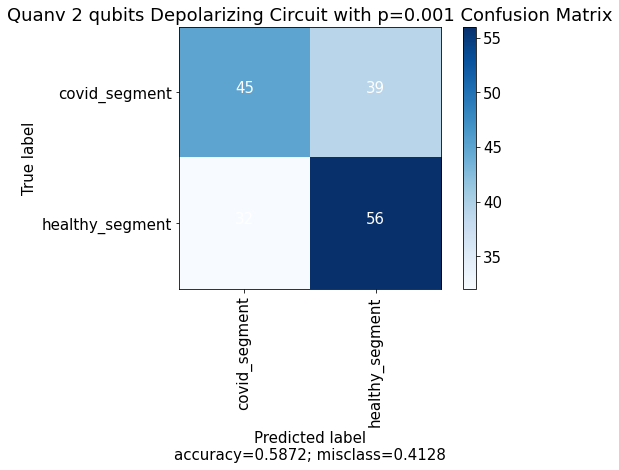

22/22 [==============================] - 1s 33ms/step

Quanv Train Accuracy: 0.92


Quanv Valid Accuracy: 0.67



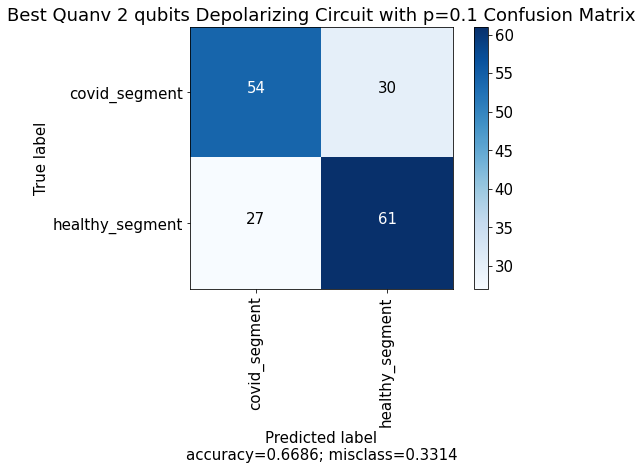

In [77]:
if ql3 == 1:
    modelq=modelq3 
    y_pred=modelq.predict(q_valid3)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train3)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 2 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo23.hdf5') 
    y_pred=modelq.predict(q_valid3)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train3)
    y_pred2= (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 2 qubits Depolarizing Circuit with p=0.1 Confusion Matrix")

22/22 [==============================] - 1s 31ms/step

Quanv Train Accuracy: 1.00


Quanv Valid Accuracy: 0.51



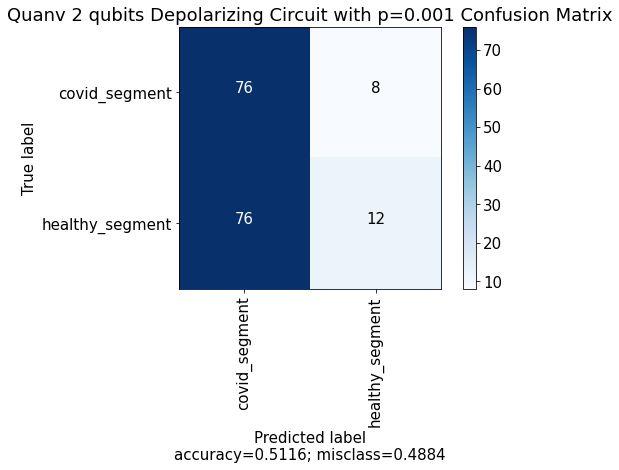

22/22 [==============================] - 1s 31ms/step

Quanv Train Accuracy: 0.57


Quanv Valid Accuracy: 0.59



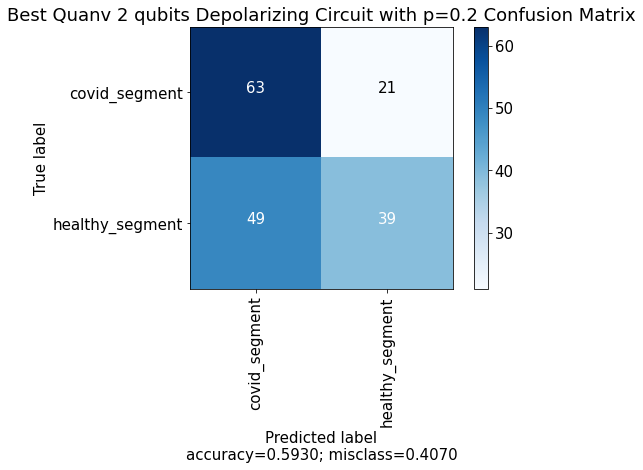

In [78]:
if ql4 == 1:
    modelq=modelq4 
    y_pred=modelq.predict(q_valid4)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train4)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Quanv 2 qubits Depolarizing Circuit with p=0.001 Confusion Matrix")
    
    modelq=keras.models.load_model('checkpoints/best_quanv_demo24.hdf5') 
    y_pred=modelq.predict(q_valid4)
    y_pred1 = (y_pred > 0.5) 
    y_pred=modelq.predict(q_train4)
    y_pred2 = (y_pred > 0.5) 

    y_pred=np.argmax(y_pred1, axis=1)
    print('\nQuanv Train Accuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred2)))
    print('\nQuanv Valid Accuracy: {:.2f}\n'.format(accuracy_score(y_valid, y_pred1)))
    cm = metrics.confusion_matrix(y_test, y_pred)


    plot_confusion_matrix(cm , 
                          normalize    = False,
                          target_names = labels,
                          title        = "Best Quanv 2 qubits Depolarizing Circuit with p=0.2 Confusion Matrix")

In [ ]:
plot_acc_loss(q_history1, q_history2, q_history3, q_history4)

In [ ]:
def to_rgb2(heatmap, h_x, w_x):
    heatmap = np.uint8(255 * vis_map(np.rot90(heatmap[0])))
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[np.rot90(np.transpose(heatmap))]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)

    jet_heatmap = jet_heatmap.resize((  h_x, w_x))

    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Save the superimposed image
    save_path = "images/color_cam.jpg"
    superimposed_img = keras.preprocessing.image.array_to_img(jet_heatmap)
    superimposed_img.save(save_path)

    cam_img= mpimg.imread(save_path)

    return cam_img

In [ ]:
from tensorflow.keras import models
import matplotlib.cm as cm
import matplotlib.image as mpimg
def layer_output(in_feats, model, ly_name = "batch_normalization_6 ", k= idx):
    conv_layer = model.get_layer(ly_name)
    heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(in_feats[k:k+1])
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    return heatmap, conv_output, predictions

In [ ]:
def vis_map(heatmap):
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    return heatmap

In [ ]:
idx = 40
w_x, h_x = x_train[idx,:,:,0].shape

#q_heatmap, q_covout, q_predict = layer_output(q_train1, modelq, "ConvDown2",k=idx)
#q_cam = to_rgb2(q_heatmap, h_x, w_x)

x_heatmap, x_covout, x_predict= layer_output(x_train, modelx, "ConvDown2",k=idx)
x_cam = to_rgb2(x_heatmap, h_x, w_x)

c_heatmap, c_covout, c_predict = layer_output(x_train, modelc, "ConvDown2",k=idx)
c_cam = to_rgb2(c_heatmap, h_x, w_x)

In [ ]:
a = 12
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(librosa.power_to_db(x_train[idx,:,:,0], ref=np.max))
plt.xticks([])
plt.yticks([])
plt.title('(a) Input Mel-Spectrogram', fontsize=a)
# plt.matshow(np.transpose(vis_map(x_train[idx,:,:,0])))
plt.subplot(2, 2, 2)
plt.imshow(q_cam)
plt.xticks([])
plt.yticks([])
plt.title('(b) Quanv + RNN', fontsize=a)
plt.subplot(2 ,2, 3)
plt.imshow(x_cam)
plt.xticks([])
plt.yticks([])
plt.title('(c) Conv + RNN', fontsize=a)
plt.subplot(2 ,2, 4)
plt.imshow(c_cam)
plt.xticks([])
plt.yticks([])
plt.title('(d) Baseline RNN', fontsize=a)
plt.tight_layout()
plt.savefig("images/cam_sp_"+str(idx)+".png")